In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import trange

from xgboost import XGBRegressor

In [46]:
#read the xslc file and create a dataframe
df = pd.read_excel('IM2S_GHS_RSS_Bloc_2019_2022_anonyme.xlsx')

In [47]:
# Renommage des colonnes
df.rename(
    columns={
        'Date EntrÈe': 'date_entree',
        'Date Sortie': 'date_sortie',
        'Date Naissance': 'date_naissance',
        'Sexe': 'sexe',
        'CIM Diag Pr.': 'cim_diag_pr',
        'CCAM 1': 'ccam_1',
        'CCAM 2': 'ccam_2',
        'CCAM 3': 'ccam_3',
        'CCAM 4': 'ccam_4',
        'GHM Code': 'ghm_code',
        'Anesthesiste': 'anesthesiste',
        'Chirurgien': 'chirurgien',
        'AnnÈe': 'annee',
        'ID Patient': 'id_patient',
        'Date Inter': 'date_inter',
        'Nom Patient': 'nom_patient',
        "Heure entrée SSPI avant intervention (cela correspond à un SAS de pré-anesthésie). Si cette heure est la même que l'heure d'entrée en salle d'opération, cela signifie qu'il n'y as pas eu de passage en SSPI pré op": 'heure_entree_sspi',
        "Heure d'entrée en salle d'opération (calimed)": 'heure_entree_salle',
        'Heure Incision ': 'heure_incision',
        "Heure de sortie de salle d'opération (calimed)" : 'heure_sortie_salle',
        'Anesth Type' : 'anesth_type',
        'Anesth Loco_reg' : 'anesth_loco_reg',
        'DurÈe Sèjour en jour (1 pour ambu)' : 'duree_sejour',
        'Interv Type' : 'interv_type',
    },
    inplace=True
)

# Suppression des lignes non pertinentes
#df = df.query("interv_type != 'Varices'")

# Suppression des lignes sans durée de séjour
df = df.query("duree_sejour < 1000")

# Conversion des dates en datetime
df['heure_entree_sspi'] = pd.to_timedelta(df['heure_entree_sspi'].astype(str))
df['heure_entree_salle'] = pd.to_timedelta(df['heure_entree_salle'].astype(str))
df['heure_incision'] = pd.to_timedelta(df['heure_incision'].astype(str))
df['heure_sortie_salle'] = pd.to_timedelta(df['heure_sortie_salle'].astype(str))

# Calcul de la durée d'opération
df['duree_sspi'] = df['heure_entree_salle'] - df['heure_entree_sspi']
df['duree_op'] = df['heure_sortie_salle'] - df['heure_entree_salle']

# Calcul de l'âge
df['age'] = df['date_entree'] - df['date_naissance']

# Ajout de la colonne urgence
df['urgence'] = df.cim_diag_pr.str.startswith('S')

# Codage des variables
df['cim_diag_pr'] = df['cim_diag_pr'].astype('category').cat.codes
df['ccam_1'] = df['ccam_1'].astype('category').cat.codes
df['ccam_2'] = df['ccam_2'].astype('category').cat.codes
df['ccam_3'] = df['ccam_3'].astype('category').cat.codes
df['ccam_4'] = df['ccam_4'].astype('category').cat.codes
df['ghm_code'] = df['ghm_code'].astype('category').cat.codes
df['anesthesiste'] = df['anesthesiste'].astype('category').cat.codes
df['chirurgien'] = df['chirurgien'].astype('category').cat.codes
df['anesth_type'] = df['anesth_type'].astype('category').cat.codes
df['anesth_loco_reg'] = df['anesth_loco_reg'].astype('category').cat.codes
df['interv_type'] = df['interv_type'].astype('category').cat.codes

In [48]:
df_vacations = df[['chirurgien','date_inter']]

In [49]:
df_vacations['travail']=True

C:\Users\33605\AppData\Local\Temp\ipykernel_10536\3887147611.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [50]:
df_vacations = df_vacations.set_index(['chirurgien','date_inter'])

In [51]:
df_vacations.groupby([pd.Grouper(level='chirurgien'),pd.Grouper(level='date_inter',freq='1D')]).sum()

travail
chirurgien date_inter         
-1         2019-01-19        1
           2019-01-22        1
           2019-01-28        1
           2019-02-02        1
           2019-02-27        1
...                        ...
 20        2022-11-29        2
           2022-12-13        1
           2022-12-15        1
           2022-12-20        2
           2022-12-30        1

[4411 rows x 1 columns]

In [52]:
df_vacations

travail
chirurgien date_inter         
16         2019-01-04     True
           2019-01-07     True
           2019-01-07     True
           2019-01-07     True
15         2019-01-04     True
...                        ...
3          2022-11-17     True
1          2022-12-07     True
14         2022-11-17     True
1          2022-11-04     True
3          2022-11-24     True

[14618 rows x 1 columns]

In [24]:
X_train.shape

(11694, 2)

In [35]:
df_chirurgien_2_counts

,travail
date_inter,
2019-01-02,1
2019-01-03,0
2019-01-04,6
2019-01-05,0
2019-01-06,0
...,...
2022-12-26,0
2022-12-27,0
2022-12-28,0


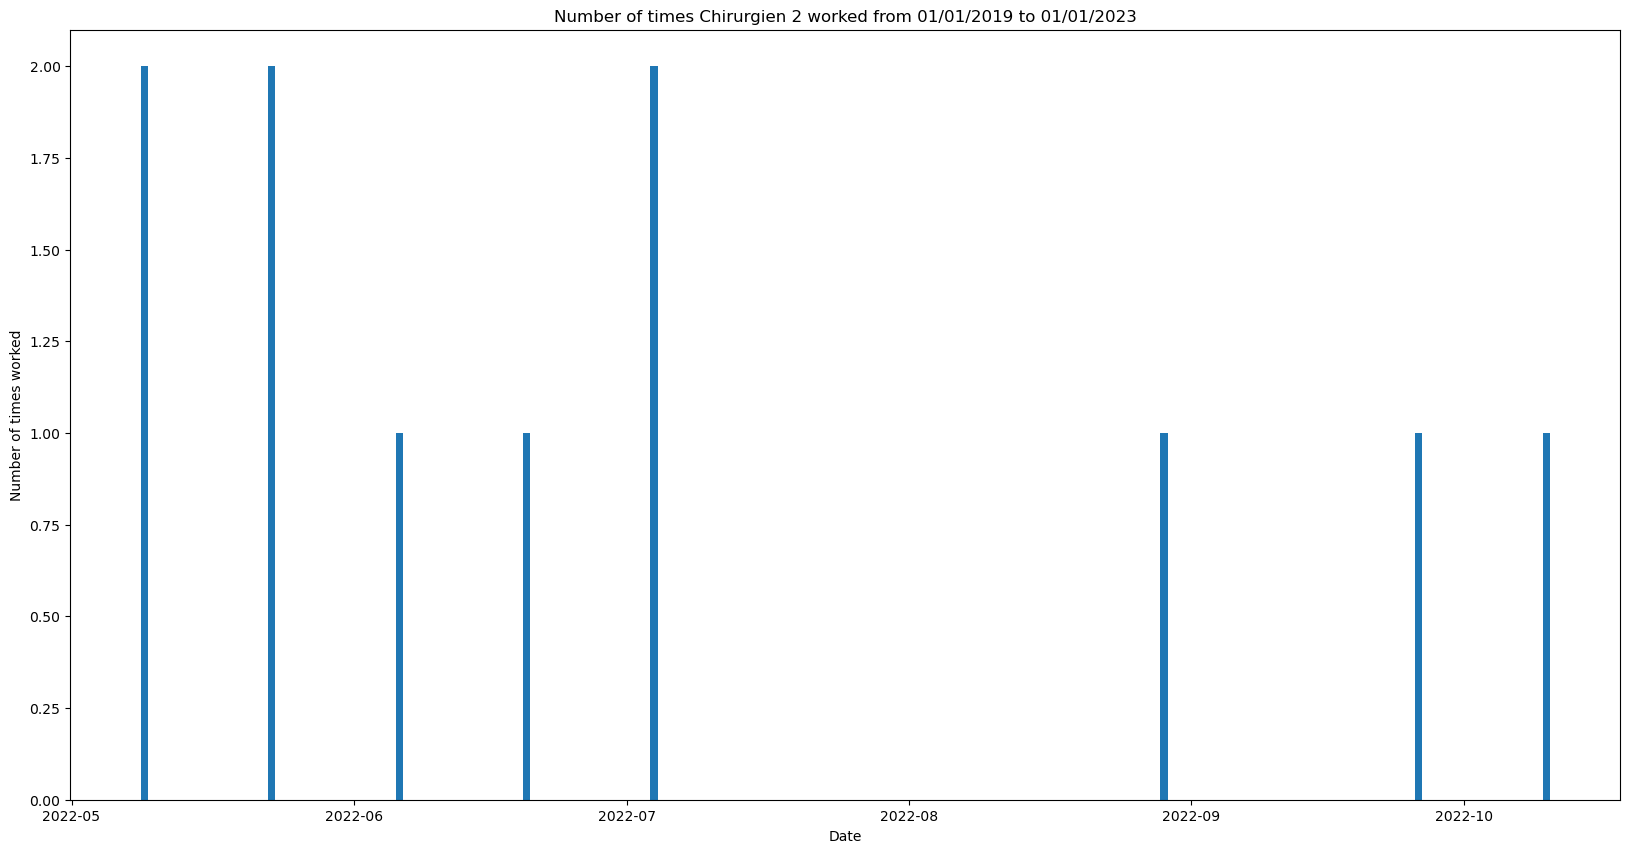

In [53]:
# filter the data to only include chirurgien number 2
df_chirurgien_2 = df_vacations.loc[18]

# group the data by date and chirurgien, and count the number of times chirurgien number 2 worked on each date
df_chirurgien_2_counts = df_chirurgien_2.groupby(pd.Grouper(freq='7D')).count()
plt.figure(figsize=(20,10))
# create a histogram plot of the data
plt.bar(df_chirurgien_2_counts.index,df_chirurgien_2_counts['travail'])
plt.title('Number of times Chirurgien 2 worked from 01/01/2019 to 01/01/2023')
plt.xlabel('Date')
plt.ylabel('Number of times worked')
plt.show()


In [57]:
df_chirurgien_2_counts

,travail
date_inter,
2022-05-09,2
2022-05-16,0
2022-05-23,2
2022-05-30,0
2022-06-06,1
2022-06-13,0
2022-06-20,1
2022-06-27,0
2022-07-04,2


In [59]:
# create a xgboost model to predict the number of times chirurgien number 2 will work on each date

#train test split
X_train, X_test, y_train, y_test = train_test_split(df_chirurgien_2_counts.index,df_chirurgien_2_counts['travail'],test_size=0.2,shuffle=False)

In [61]:
model = XGBRegressor(objective='reg:squarederror',n_estimators=1000)

In [74]:
X_train.values.reshape(-1,1).astype('float64')

array([[1.6520544e+18],
       [1.6526592e+18],
       [1.6532640e+18],
       [1.6538688e+18],
       [1.6544736e+18],
       [1.6550784e+18],
       [1.6556832e+18],
       [1.6562880e+18],
       [1.6568928e+18],
       [1.6574976e+18],
       [1.6581024e+18],
       [1.6587072e+18],
       [1.6593120e+18],
       [1.6599168e+18],
       [1.6605216e+18],
       [1.6611264e+18],
       [1.6617312e+18],
       [1.6623360e+18]])

In [75]:
model.fit(X_train.values.reshape(-1,1).astype('float64'),y_train.values.reshape(-1,1))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
model.score(X_test.values.reshape(-1,1).astype('float64'),y_test.values.reshape(-1,1))

-0.66236243534747